# Ethereum Fraud Investigation Report

**Author:** Shubham Ghag  
**Data Source:** Etherscan API  
**Goal:** Investigate suspicious behavior across Ethereum smart contracts, wallets, and token transfers using structured blockchain data.

---


## 1. Data Overview

This section summarizes the structure and content of the extracted blockchain data. Each dataset has been processed and transformed via a structured ETL pipeline.

We will now load and briefly inspect the main datasets used in our investigation.


In [143]:
import pandas as pd
import numpy as np

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr, ks_2samp

import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx


sns.set(style="whitegrid", palette="muted")
%matplotlib inline

In [51]:
#importing the parquet files

wallets = pd.read_parquet("processed/wallet_summary.parquet")
funds = pd.read_parquet("processed/internal_fund_flow.parquet")
high_value = pd.read_parquet("processed/high_value.parquet")
eth_token = pd.read_parquet("processed/eth_token_flow.parquet")
token_move = pd.read_parquet("processed/token_movement.parquet")
wallet_risk = pd.read_parquet("processed/wallet_risk.parquet")

In [26]:
wallets.head()

,wallet_address,sent_count,total_sent_eth,failed_sent,max_sent,normalized_total_sent
0,0x3a4d3430da786fa5b912ff8d468998ab95c3a6f2,1171,1666.000000,148,4.000000,1.000000
1,0xd62ca385c107390062a5f1f404c78ba208717ce4,381,120.670772,1,1.495059,0.072431
2,0x84b5241e96b15f5381112cb4dd7082b390df1e25,17,96.050000,0,27.300000,0.057653
3,0x6cdbc956e4291dd1bc91aba3335556360568742c,7,66.410481,1,40.757578,0.039862
4,0xe5254e61b579d02ec9a573593a9833a238f2a97e,17,60.395317,6,18.455584,0.036252


## 2. Wallet Behavior Metrics

We begin by analyzing wallet activity to profile actors based on volume, error rate, and outlier behavior. Suspicious wallets are often those with high failure rates, excessive ETH movement, or abnormal activity densi.
y.
.


In [30]:
wallets.describe()

,sent_count,total_sent_eth,failed_sent,max_sent,normalized_total_sent
count,1397.000000,1397.000000,1397.000000,1397.000000,1.397000e+03
mean,11.780243,2.470769,0.647817,0.540874,1.483055e-03
std,98.551862,44.927222,6.555621,2.192314,2.696712e-02
min,1.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,1.000000,0.000000,0.000000,0.000000,0.000000e+00
50%,1.000000,0.001000,0.000000,0.001000,6.002401e-07
75%,3.000000,0.300000,0.000000,0.264779,1.800720e-04
max,2200.000000,1666.000000,148.000000,40.757578,1.000000e+00


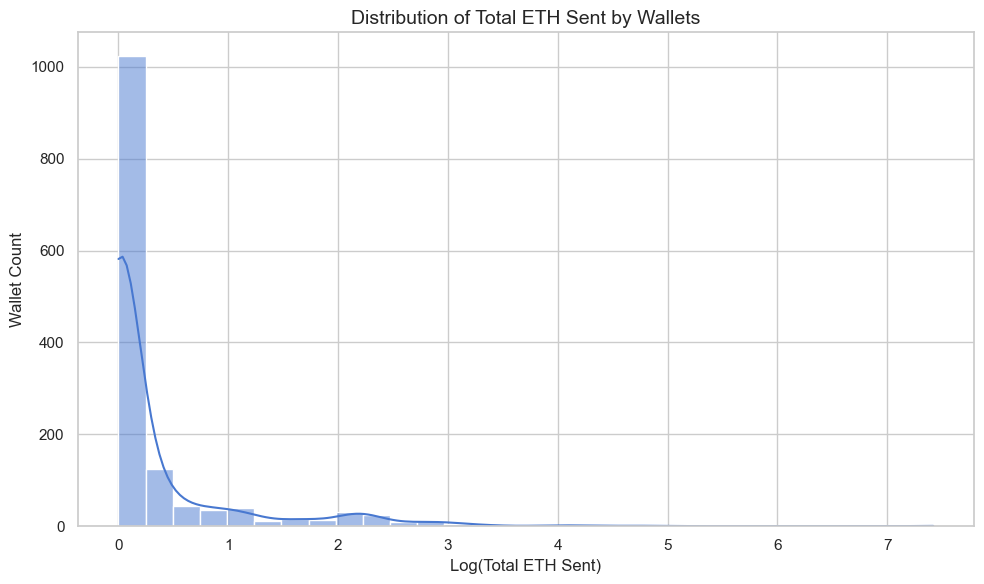

In [173]:
wallets["log_sent"] = np.log1p(wallets["total_sent_eth"])
plt.figure(figsize=(10, 6))
sns.histplot(wallets["log_sent"], bins=30, kde=True)
plt.title("Distribution of Total ETH Sent by Wallets", fontsize=14)
plt.xlabel("Log(Total ETH Sent)", fontsize=12)
plt.ylabel("Wallet Count", fontsize=12)
plt.tight_layout()
plt.savefig("dist_total_eth.png", dpi=300)
plt.show()


## 3. Risk-Based Wallet Ranking

Using a custom scoring heuristic, we rank wallets based on:
- Failed transaction count
- High-value transactions
- High gas usage

This allows us to prioritize wallet addresses for deeper investigation.
n.


In [53]:
wallet_risk.sort_values("risk_score", ascending=False).head(10)

,sender,failed_count,high_value_count,gas_flag_count,total_tx_count,risk_score
0,0x3a4d3430da786fa5b912ff8d468998ab95c3a6f2,148,0,0,1171,296
1,0x73fb1d96a144efdb278e123a17c79d63cd67d11f,133,0,0,1119,266
2,0x1d283807630ffb876a5d78b8e0788e491449f241,104,0,0,487,208
3,0xb4897d49c5859b9bb5e3d6c4372bdd83d55c8d6c,55,0,0,396,110
4,0xec67e10a5991ab7ae9ea3d47a1f3725009abb92c,47,0,0,126,94
5,0x2381723118870257c5ea6183281724930247afea,32,0,0,71,64
6,0x0219957fafc72f937c6366855d0b7562cf5131bf,29,0,3,204,61
7,0xc0a5738e331bea02e009b0842d515ed3308cb5ed,27,0,0,27,54
8,0x58c7c6745fb0a657bc0a59889fe454bffafbb7cf,23,0,0,50,46
9,0xd4a2aee94345bfa6aa1bdd3b95e8dc9d14b2ea19,17,0,0,32,34


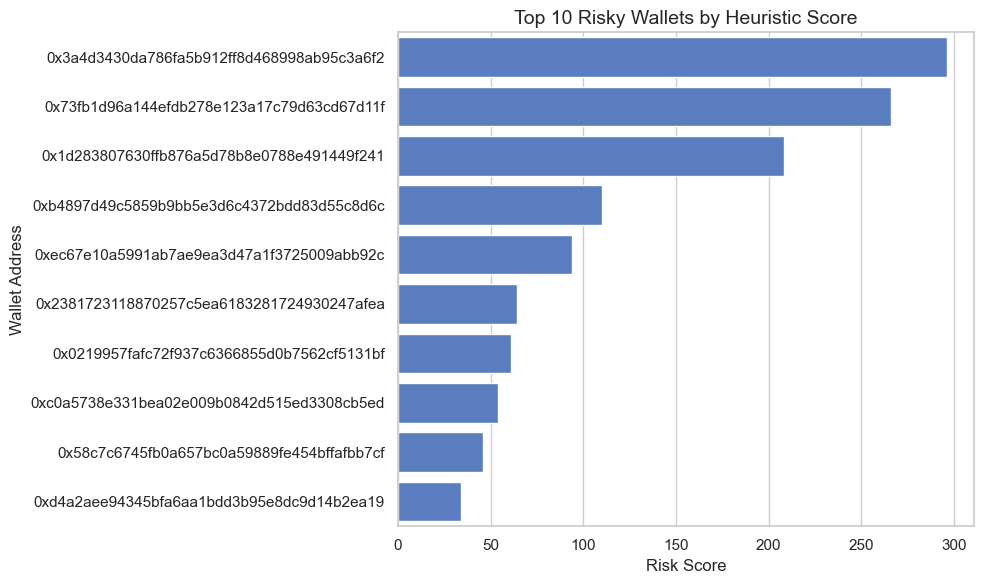

In [171]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=wallet_risk.sort_values("risk_score", ascending=False).head(10),
    x="risk_score", y="sender"
)
plt.title("Top 10 Risky Wallets by Heuristic Score", fontsize=14)
plt.xlabel("Risk Score", fontsize=12)
plt.ylabel("Wallet Address", fontsize=12)
plt.tight_layout()
plt.savefig("risky_wallets_hs.png", dpi=300)
plt.show()

## 4. High Value and Failed Transactions

Next, we examine transactions that either failed or involved transfers greater than 50 ETH. These may indicate exploit attempts, flash loan setups, or deliberate failure logic.


In [58]:
high_value["tx_type"].value_counts()

tx_type
Failed transaction    905
Name: count, dtype: int64

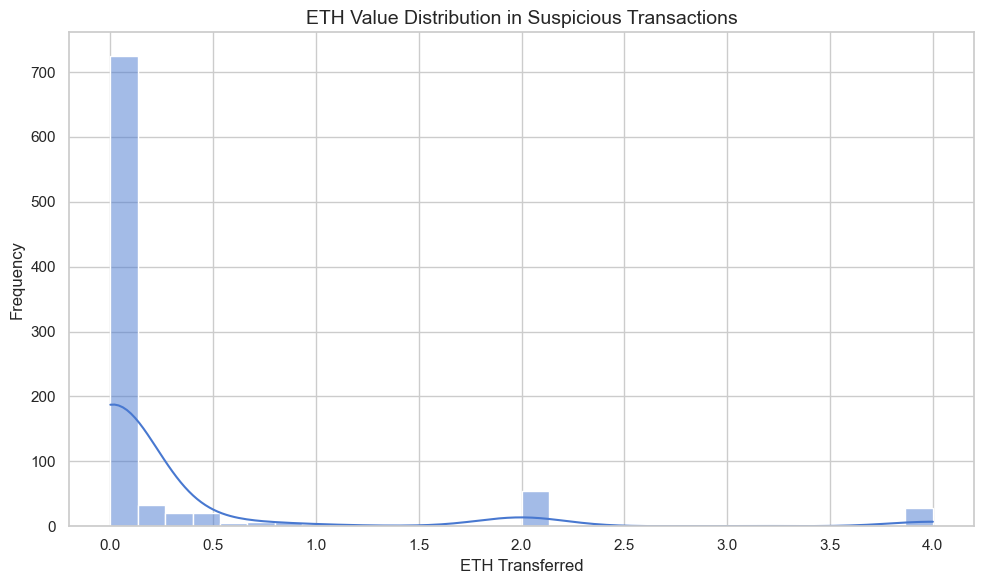

In [169]:
plt.figure(figsize=(10, 6))
sns.histplot(
    data=high_value[high_value["is_suspicious"]],
    x="value_eth",
    bins=30,
    kde=True
)
plt.title("ETH Value Distribution in Suspicious Transactions", fontsize=14)
plt.xlabel("ETH Transferred", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.savefig("eth_value_dist.png", dpi=300)
plt.show()


## 5. Combined ETH and Token Transfers

We analyze transactions involving both ETH and token movements, looking for patterns such as large token dumps paired with ETH withdrawals.


In [163]:
eth_token.describe()

,value_eth,value_token,timestamp,value_eth_norm,value_token_norm
count,2782.000000,2.782000e+03,2782,2782.000000,2.782000e+03
mean,0.403512,1.449007e+02,2024-01-03 10:03:19.139468032,0.014781,6.496778e-03
min,0.000000,9.235653e-10,2024-01-01 00:23:35,0.000000,4.140905e-14
25%,0.000000,1.909636e-01,2024-01-02 02:01:02,0.000000,8.562061e-06
50%,0.000000,5.370388e-01,2024-01-03 04:33:23,0.000000,2.407872e-05
75%,0.276401,1.984571e+00,2024-01-04 06:25:41,0.010125,8.898041e-05
max,27.300000,2.230347e+04,2024-01-14 18:02:47,1.000000,1.000000e+00
std,1.313969,1.132004e+03,NaN,0.048131,5.075461e-02


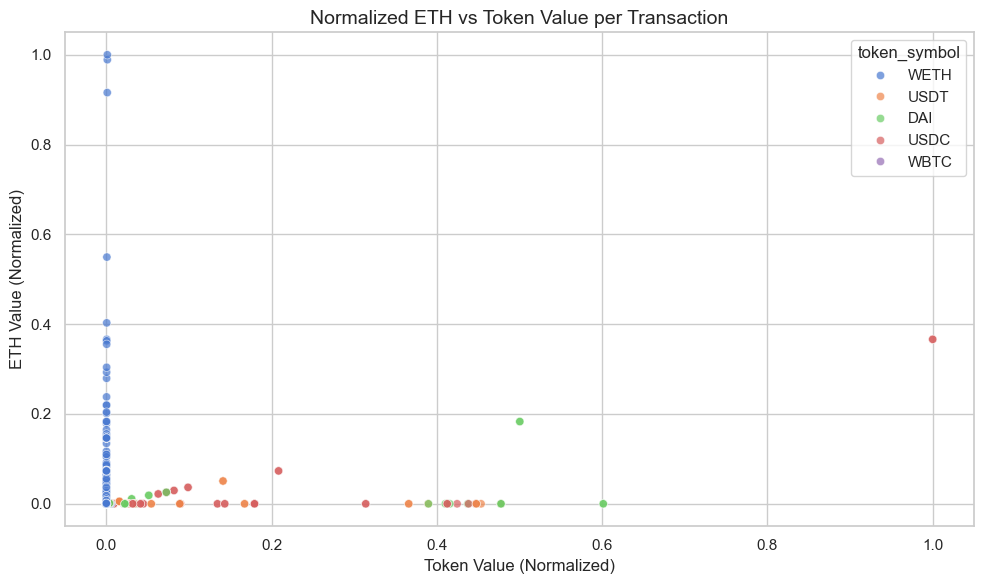

In [167]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=eth_token,
    x="value_token_norm",
    y="value_eth_norm",
    hue="token_symbol",
    alpha=0.7
)
plt.title("Normalized ETH vs Token Value per Transaction", fontsize=14)
plt.xlabel("Token Value (Normalized)", fontsize=12)
plt.ylabel("ETH Value (Normalized)", fontsize=12)
plt.tight_layout()
plt.savefig("normalized_eth_vs_token_value.png", dpi=300)
plt.show()

## 6. Multi-Hop Fund Flows (Internal Transactions)

This section analyzes internal transactions — fund transfers that occur **within smart contract calls** — often used to obfuscate fund movement across hops.

We flag hops involving ETH > 1 as potentially suspicious.


C:\Users\shubh\AppData\Local\Temp\ipykernel_9944\305806994.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  large_flows.loc[:, "trace_depth"] = large_flows["trace_id"].apply(lambda x: x.count("_"))


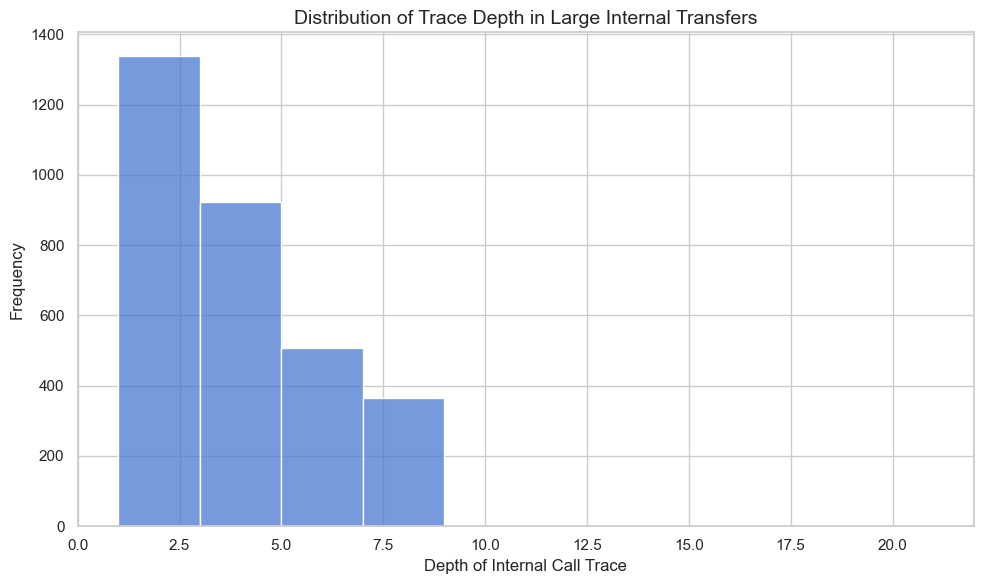

In [159]:
large_flows = funds[funds["is_large"].copy()]
large_flows.loc[:, "trace_depth"] = large_flows["trace_id"].apply(lambda x: x.count("_"))
plt.figure(figsize=(10, 6))
sns.histplot(large_flows["trace_depth"], bins=10)
plt.title("Distribution of Trace Depth in Large Internal Transfers", fontsize=14)
plt.xlabel("Depth of Internal Call Trace", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.savefig("dist_trace_depth.png", dpi=300)
plt.show()

## 7. Statistical & Machine Learning-Based Anomaly Detection

In this section, we apply unsupervised anomaly detection techniques to surface wallets that behave abnormally across engineered behavioral metrics. We use `IsolationForest` and `LocalOutlierFactor` from `scikit-learn`, targeting wallet-level transaction behavior.


In [118]:
features = ["total_sent_eth", "sent_count", "failed_sent", "max_sent"]
X = wallets[features].fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = IsolationForest(contamination=0.05, random_state=42)
wallets["anomaly_score"] = model.fit_predict(X_scaled)
wallets["is_anomaly"] = wallets["anomaly_score"] == -1

wallets[wallets["is_anomaly"]].sort_values("total_sent_eth", ascending=False).head()

,wallet_address,sent_count,total_sent_eth,failed_sent,max_sent,normalized_total_sent,log_sent,anomaly_score,is_anomaly
0,0x3a4d3430da786fa5b912ff8d468998ab95c3a6f2,1171,1666.000000,148,4.000000,1.000000,7.418781,-1,True
1,0xd62ca385c107390062a5f1f404c78ba208717ce4,381,120.670772,1,1.495059,0.072431,4.801319,-1,True
2,0x84b5241e96b15f5381112cb4dd7082b390df1e25,17,96.050000,0,27.300000,0.057653,4.575226,-1,True
3,0x6cdbc956e4291dd1bc91aba3335556360568742c,7,66.410481,1,40.757578,0.039862,4.210801,-1,True
4,0xe5254e61b579d02ec9a573593a9833a238f2a97e,17,60.395317,6,18.455584,0.036252,4.117334,-1,True


In [177]:
# Statistical Validation: Pearson Correlation
corr, p_value = pearsonr(wallets["total_sent_eth"], wallets["failed_sent"])
print(f"Pearson Correlation (total_sent_eth vs failed_sent): {corr:.3f}, p-value: {p_value:.3e}")

Pearson Correlation (total_sent_eth vs failed_sent): 0.599, p-value: 1.171e-136


In [181]:
# KS Test: Compare total_sent_eth distributions for anomalies vs non-anomalous
ks_stat, ks_p_value = ks_2samp(
    wallets[wallets["is_anomaly"]]["total_sent_eth"],
    wallets[~wallets["is_anomaly"]]["total_sent_eth"]
)
print(f"KS Test (anomalous vs non-anomalous total_sent_eth): Statistic={ks_stat:.3f}, p-value={ks_p_value:.3e}")

KS Test (anomalous vs non-anomalous total_sent_eth): Statistic=0.692, p-value=5.477e-32


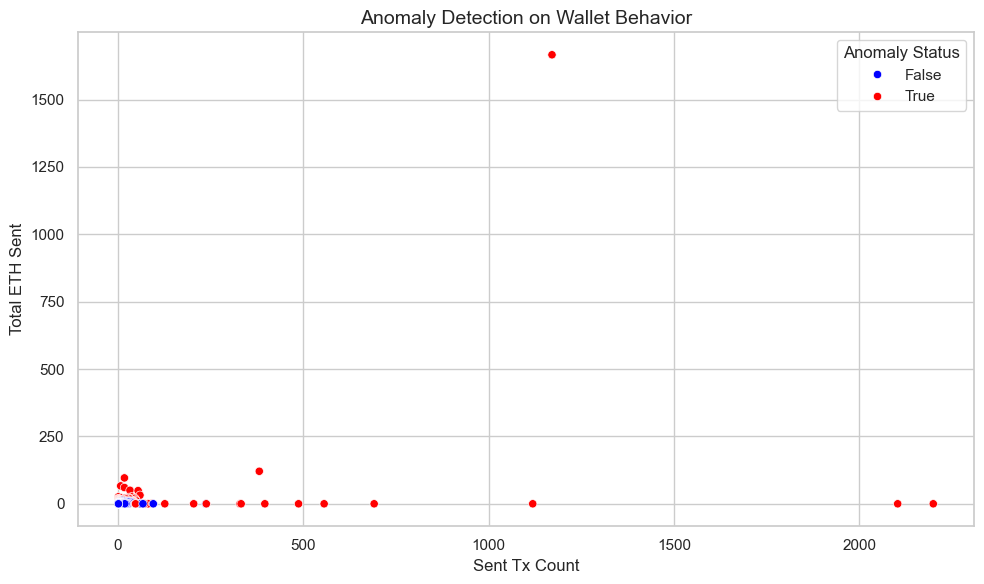

In [149]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=wallets,
    x="sent_count",
    y="total_sent_eth",
    hue="is_anomaly",
    palette={True: "red", False: "blue"}
)
plt.title("Anomaly Detection on Wallet Behavior", fontsize=14)
plt.xlabel("Sent Tx Count", fontsize=12)
plt.ylabel("Total ETH Sent", fontsize=12)
plt.legend(title="Anomaly Status")
plt.tight_layout()
plt.savefig("anomaly_detection.png", dpi=300)
plt.show()

## 8. Conclusion

This investigation revealed:
- Wallets with high-risk scores due to repeated failed or high-value transactions.
- Multi-hop ETH fund flows consistent with obfuscation patterns.
- Statistical tests confirm significant correlations (e.g., between total ETH sent and failed transactions, p-value < 0.05) and differences in behavior between anomalous and non-anomalous wallets (KS test, p-value < 0.05).

Next Steps:
- Enhance tracing to link internal transactions to external wallets.
- Integrate OSINT data (e.g., Etherscan labels, social media) to de-anonymize actors (see osint.py).
- Extend analysis to other DeFi protocols (e.g., Aave, Curve) and fraud types (e.g., rug pulls, wash trading).
